In [3]:
import pandas as pd
import re
import bs4
import requests
import spacy
from spacy import displacy
nlp=spacy.load("en_core_web_sm")
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [9]:
ls

drive/  sample_data/  wiki_sentences_v2.csv


In [10]:
#import the data
df=pd.read_csv("wiki_sentences_v2.csv")
df.head()

,sentence
0,"confused and frustrated, connie decides to leave on her own."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [14]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


In [15]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [22]:
get_entities("the big man who saw me")

['big  who', 'me']

In [24]:
for i in nlp("the big man who saw me"):
  print(i.text,"---",i.pos_,"---",i.dep_)

the --- DET --- det
big --- ADJ --- amod
man --- NOUN --- ROOT
who --- PRON --- nsubj
saw --- VERB --- relcl
me --- PRON --- dobj


In [56]:
entities=df.sentence.apply(lambda x: get_entities(x))

In [27]:
df.entities.head()

0               [connie, own]
1    [later  woman, distance]
2    [christian, then  elder]
3              [temple, fire]
4        [outside  cult, him]
Name: entities, dtype: object

In [39]:
def get_relation(sent):
  doc = nlp(sent)
  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 
  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [57]:
relations=df.sentence.apply(lambda x:get_relation(x))

In [41]:
df.relation.value_counts()

is             370
was            297
released on     87
include         73
were            71
              ... 
shot at          1
ambushed by      1
gandalf          1
saying           1
garbo by         1
Name: relation, Length: 1605, dtype: int64

In [42]:
df.head()

,sentence,entities,relation
0,"confused and frustrated, connie decides to leave on her own.","[connie, own]",decides
1,"later, a woman’s scream is heard in the distance.","[later woman, distance]",heard in
2,christian is then paralyzed by an elder.,"[christian, then elder]",paralyzed by
3,the temple is set on fire.,"[temple, fire]",set on
4,"outside, the cult wails with him.","[outside cult, him]",wails with


In [58]:
source=[i[0] for i in entities]
target=[i[1] for i in entities]

In [59]:
#crete new dataframe
kg_df=pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [60]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

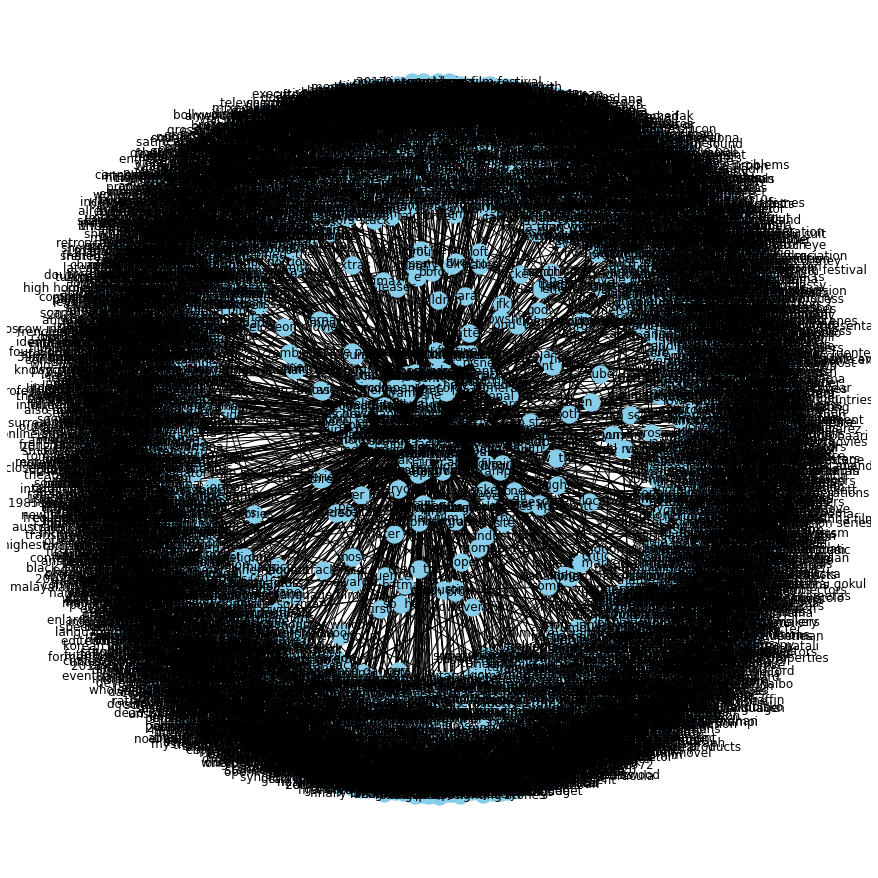

In [61]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

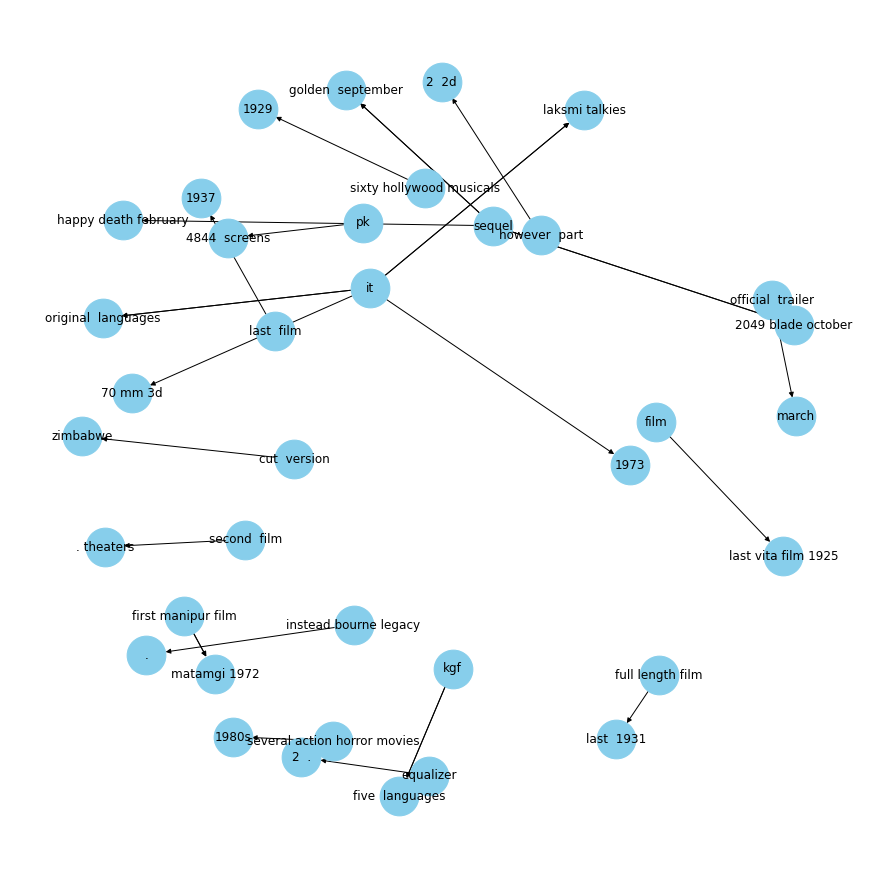

In [65]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df[kg_df.edge=='released in'], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G,k=0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500,edge_cmap=plt.cm.Blues, pos = pos)
plt.show()